<a href="https://colab.research.google.com/github/lahirumanulanka/ai-notebooks/blob/main/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/lahirumanulanka/ann-visual-emotion

Cloning into 'ann-visual-emotion'...
remote: Enumerating objects: 34989, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 34989 (delta 18), reused 33 (delta 9), pack-reused 34941 (from 2)
Receiving objects: 100% (34989/34989), 1.43 GiB | 40.67 MiB/s, done.
Resolving deltas: 100% (6802/6802), done.
Updating files: 100% (34856/34856), done.


## 1) Setup & Imports

In [2]:
import os, math, json, random, time
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 2) Config & Label Map

In [4]:
BASE_DIR = "/content/ann-visual-emotion/data/processed/EmoSet_splits"
BASE_DATA_URL = "/content/ann-visual-emotion"

# File paths
CSV_TRAIN = f"{BASE_DIR}/train.csv"
CSV_VAL   = f"{BASE_DIR}/val.csv"
CSV_TEST  = f"{BASE_DIR}/test.csv"

# Column names in the CSVs
COL_IMAGE = 'image'
COL_LABEL = 'label'

# Training hyperparameters
IMG_SIZE     = 224
BATCH_SIZE   = 32
EPOCHS       = 20
BASE_LR      = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.05
USE_SAMPLER  = True            # balanced mini-batches
MIXUP_ALPHA  = 0.0             # set to 0.2~0.4 to enable MixUp

# Checkpoint path
CKPT_PATH = 'best_resnet18_balanced.pt'

## 3) Load CSVs & Quick EDA

In [5]:
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print(train_df.head())

Train: 13864 Val: 1734 Test: 1734
                                          image_path        label
0  data/raw/EmoSet/contentment/contentment_09260.jpg  contentment
1              data/raw/EmoSet/anger/anger_06224.jpg        anger
2  data/raw/EmoSet/contentment/contentment_03550.jpg  contentment
3          data/raw/EmoSet/sadness/sadness_08827.jpg      sadness
4  data/raw/EmoSet/contentment/contentment_09558.jpg  contentment


In [6]:

def _auto_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found. Columns: {list(df.columns)}")


def load_csvs(csv_train, csv_val, csv_test=None, col_image='image_path', col_label='label'):
    tr = pd.read_csv(csv_train)
    va = pd.read_csv(csv_val)
    te = pd.read_csv(csv_test) if csv_test and os.path.exists(csv_test) else None

    if col_image not in tr.columns:
        col_image = _auto_column(tr, ['image_path','image','filepath','path','img_path','img'])
    if col_label not in tr.columns:
        col_label = _auto_column(tr, ['label','emotion','target','y'])

    for df in (tr, va) + ((te,) if te is not None else ()):
        df[col_image] = df[col_image].astype(str)
        df[col_label] = df[col_label].astype(str)

    labels = sorted(tr[col_label].unique().tolist())
    label_to_idx = {l:i for i,l in enumerate(labels)}
    idx_to_label = {i:l for l,i in label_to_idx.items()}

    tr['y'] = tr[col_label].map(label_to_idx)
    va['y'] = va[col_label].map(label_to_idx)
    if te is not None:
        before = len(te)
        te = te[te[col_label].isin(labels)].copy()
        if len(te) < before:
            print(f"[WARN] Dropped {before-len(te)} test rows with unseen labels.")
        te['y'] = te[col_label].map(label_to_idx)

    return tr, va, te, label_to_idx, idx_to_label, col_image, col_label


def resolve_path(p: str) -> str:
    """Return an absolute path. If not existing, try join with BASE_DATA_URL."""
    # Already absolute and exists
    if os.path.isabs(p) and os.path.exists(p):
        return p
    # Try relative to BASE_DATA_URL
    cand = os.path.join(BASE_DATA_URL, p.lstrip('/'))
    if os.path.exists(cand):
        return cand
    # As last resort, return original (may be handled by PIL if path becomes valid in Colab mount)
    return p


class ImageCSVDataset(Dataset):
    def __init__(self, df, img_col, y_col='y', transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.y_col = y_col
        self.tfm = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = resolve_path(row[self.img_col])
        y = int(row[self.y_col])
        with Image.open(path) as im:
            im = im.convert('RGB')
        if self.tfm:
            im = self.tfm(im)
        return im, y


def compute_class_weights(y_int, power=0.5):
    counts = np.bincount(y_int)
    counts[counts==0] = 1
    w = (1.0 / counts) ** power
    w = w / w.sum() * len(counts)
    return torch.tensor(w, dtype=torch.float32)


def make_sampler(y_int):
    class_count = np.bincount(y_int)
    class_count[class_count==0] = 1
    class_weight = 1.0 / class_count
    sample_weight = np.array([class_weight[y] for y in y_int])
    return WeightedRandomSampler(weights=torch.from_numpy(sample_weight).double(),
                                 num_samples=len(sample_weight),
                                 replacement=True)


In [7]:
# Load CSVs
train_df, val_df, test_df, label_to_idx, idx_to_label, COL_IMAGE, COL_LABEL = load_csvs(
    CSV_TRAIN, CSV_VAL, CSV_TEST, COL_IMAGE, COL_LABEL
)
NUM_CLASSES = len(label_to_idx)
print('Classes:', label_to_idx)

# Transforms (ImageNet mean/std)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])
val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_ds = ImageCSVDataset(train_df, img_col=COL_IMAGE, transform=train_tfms)
val_ds   = ImageCSVDataset(val_df,   img_col=COL_IMAGE, transform=val_tfms)
test_ds  = ImageCSVDataset(test_df,  img_col=COL_IMAGE, transform=val_tfms) if test_df is not None else None

# Sampler / Loaders
sampler = make_sampler(train_df['y'].values) if USE_SAMPLER else None
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=(sampler is None),
                          sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True) if test_ds is not None else None

# Class weights (for CE)
class_weights = compute_class_weights(train_df['y'].values, power=0.5).to(device)
print('Class weights:', class_weights.cpu().numpy().round(3))

Classes: {'amusement': 0, 'anger': 1, 'awe': 2, 'contentment': 3, 'disgust': 4, 'excitement': 5, 'fear': 6, 'sadness': 7}
Class weights: [0.341 0.563 0.85  0.376 4.109 0.269 0.99  0.503]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
def build_model(num_classes):
    net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # freeze all
    for p in net.parameters():
        p.requires_grad = False
    # unfreeze last block
    for p in net.layer4.parameters():
        p.requires_grad = True
    in_features = net.fc.in_features
    net.fc = nn.Linear(in_features, num_classes)
    return net

model = build_model(NUM_CLASSES).to(device)

# Optimizer / Scheduler
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=BASE_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]
/tmp/ipython-input-2085706871.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [10]:
def mixup(images, labels, alpha=0.2):
    if alpha <= 0.0:
        return images, labels, labels, 1.0, False
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0), device=images.device)
    mixed_x = lam * images + (1 - lam) * images[index, :]
    y_a, y_b = labels, labels[index]
    return mixed_x, y_a, y_b, lam, True

In [11]:
def epoch_pass(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    all_preds, all_tgts = [], []
    total_loss, total_n = 0.0, 0

    for ims, ys in loader:
        ims, ys = ims.to(device), ys.to(device)
        if train:
            opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            ims2, y_a, y_b, lam, used_mix = mixup(ims, ys, alpha=MIXUP_ALPHA if train else 0.0)
            logits = model(ims2)
            if used_mix:
                loss = lam*F.cross_entropy(logits, y_a, weight=class_weights, label_smoothing=LABEL_SMOOTH) + \
                       (1-lam)*F.cross_entropy(logits, y_b, weight=class_weights, label_smoothing=LABEL_SMOOTH)
            else:
                loss = F.cross_entropy(logits, ys, weight=class_weights, label_smoothing=LABEL_SMOOTH)
        if train:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        total_loss += loss.item() * ims.size(0)
        total_n    += ims.size(0)
        all_preds.append(logits.detach().cpu())
        all_tgts.append(ys.detach().cpu())

    if train:
        scheduler.step()

    y_true = torch.cat(all_tgts).numpy()
    y_pred = torch.cat(all_preds).argmax(1).numpy()

    # macro-F1 (simple sklearn computation)
    from sklearn.metrics import f1_score, accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return total_loss/total_n, f1, acc, y_true, y_pred

In [12]:

best_f1 = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_f1, tr_acc, _, _ = epoch_pass(train_loader, train=True)
    va_loss, va_f1, va_acc, y_true, y_pred = epoch_pass(val_loader, train=False)
    dt = time.time()-t0
    print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} F1 {tr_f1:.3f} acc {tr_acc:.3f} || val_loss {va_loss:.4f} F1 {va_f1:.3f} acc {va_acc:.3f}  [{dt:.1f}s]")
    history.append((epoch, tr_loss, tr_f1, tr_acc, va_loss, va_f1, va_acc))

    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({'model': model.state_dict(),
                    'label_to_idx': label_to_idx,
                    'idx_to_label': idx_to_label}, CKPT_PATH)
        print('  -> saved best checkpoint')

# Optionally unfreeze more and continue training if plateau (run again with different setup)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 01 | train_loss 0.7365 F1 0.554 acc 0.578 || val_loss 1.8256 F1 0.369 acc 0.437  [192.1s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 02 | train_loss 0.5868 F1 0.680 acc 0.695 || val_loss 1.7254 F1 0.408 acc 0.474  [190.1s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 03 | train_loss 0.5037 F1 0.730 acc 0.744 || val_loss 1.6756 F1 0.433 acc 0.503  [185.9s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 04 | train_loss 0.4655 F1 0.768 acc 0.780 || val_loss 1.6883 F1 0.431 acc 0.495  [183.5s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 05 | train_loss 0.4328 F1 0.804 acc 0.811 || val_loss 1.6769 F1 0.446 acc 0.505  [182.8s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 06 | train_loss 0.4154 F1 0.828 acc 0.833 || val_loss 1.6262 F1 0.465 acc 0.542  [185.7s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 07 | train_loss 0.3780 F1 0.852 acc 0.856 || val_loss 1.6323 F1 0.457 acc 0.543  [183.0s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 08 | train_loss 0.3602 F1 0.878 acc 0.882 || val_loss 1.5886 F1 0.467 acc 0.548  [178.4s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 09 | train_loss 0.3541 F1 0.886 acc 0.889 || val_loss 1.6128 F1 0.476 acc 0.555  [183.7s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 10 | train_loss 0.3519 F1 0.890 acc 0.893 || val_loss 1.5914 F1 0.473 acc 0.554  [180.1s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 11 | train_loss 0.3465 F1 0.893 acc 0.897 || val_loss 1.5952 F1 0.490 acc 0.570  [179.6s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 12 | train_loss 0.3456 F1 0.893 acc 0.895 || val_loss 1.5949 F1 0.491 acc 0.573  [180.4s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 13 | train_loss 0.3443 F1 0.895 acc 0.899 || val_loss 1.6222 F1 0.498 acc 0.574  [181.5s]
  -> saved best checkpoint


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 14 | train_loss 0.3378 F1 0.895 acc 0.899 || val_loss 1.6240 F1 0.479 acc 0.570  [180.2s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 15 | train_loss 0.3393 F1 0.896 acc 0.899 || val_loss 1.6485 F1 0.485 acc 0.572  [180.2s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 16 | train_loss 0.3471 F1 0.886 acc 0.889 || val_loss 1.6875 F1 0.468 acc 0.539  [181.8s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 17 | train_loss 0.3805 F1 0.873 acc 0.876 || val_loss 1.6730 F1 0.484 acc 0.567  [179.2s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 18 | train_loss 0.3687 F1 0.871 acc 0.875 || val_loss 1.7542 F1 0.444 acc 0.546  [179.6s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 19 | train_loss 0.3729 F1 0.873 acc 0.875 || val_loss 1.7004 F1 0.447 acc 0.533  [179.8s]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation migh

Epoch 20 | train_loss 0.3696 F1 0.872 acc 0.875 || val_loss 1.8438 F1 0.442 acc 0.505  [180.8s]



Validation classification report:
              precision    recall  f1-score   support

   amusement      0.421     0.512     0.462       381
       anger      0.596     0.664     0.628       140
         awe      0.392     0.500     0.440        62
 contentment      0.509     0.452     0.479       314
     disgust      0.000     0.000     0.000         3
  excitement      0.778     0.399     0.527       614
        fear      0.468     0.489     0.478        45
     sadness      0.379     0.846     0.523       175

    accuracy                          0.505      1734
   macro avg      0.443     0.483     0.442      1734
weighted avg      0.573     0.505     0.507      1734



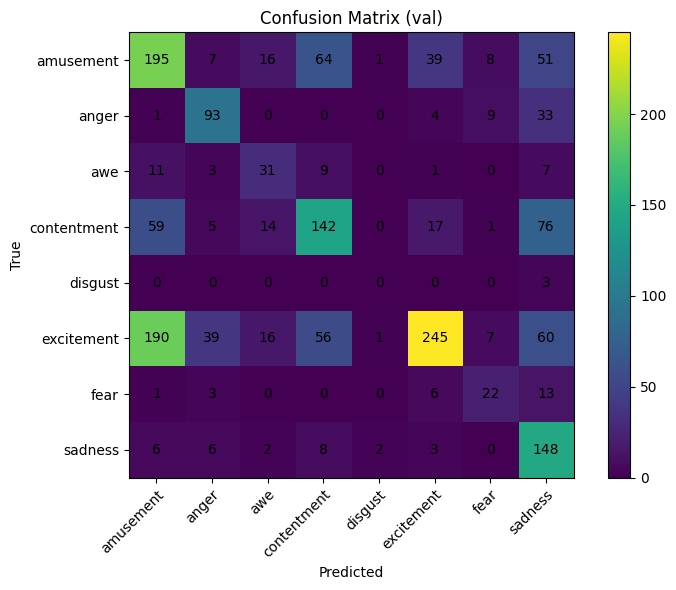

In [15]:
print('\nValidation classification report:')
target_names = [idx_to_label[i] for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(NUM_CLASSES), yticks=np.arange(NUM_CLASSES),
       xticklabels=target_names, yticklabels=target_names,
       ylabel='True', xlabel='Predicted', title='Confusion Matrix (val)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

In [16]:

if test_loader is not None:
    print('\nEvaluating on TEST set...')
    _, _, _, y_true_t, y_pred_t = epoch_pass(test_loader, train=False)
    print('Test classification report:')
    print(classification_report(y_true_t, y_pred_t, target_names=target_names, digits=3, zero_division=0))



Evaluating on TEST set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-493716025.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Test classification report:
              precision    recall  f1-score   support

   amusement      0.413     0.528     0.463       381
       anger      0.515     0.493     0.504       140
         awe      0.452     0.459     0.455        61
 contentment      0.468     0.449     0.459       314
     disgust      0.000     0.000     0.000         3
  excitement      0.798     0.393     0.526       614
        fear      0.333     0.444     0.381        45
     sadness      0.387     0.847     0.531       176

    accuracy                          0.490      1734
   macro avg      0.421     0.452     0.415      1734
weighted avg      0.563     0.490     0.492      1734

